In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import classification_report, confusion_matrix

2025-04-21 14:21:07.911700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745245268.103624      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745245268.159802      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def remove_background_otsu(image_path, save=False):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((7, 7), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    
    mask_cleaned = np.zeros_like(mask)
    cv2.drawContours(mask_cleaned, contours, -1, (255), thickness=cv2.FILLED)
    
    h, w = mask.shape
    top_cut = int(h * 0.20)
    mask_cleaned[:top_cut, :] = 0
    
    segmented = cv2.bitwise_and(gray, gray, mask=mask_cleaned)
    segmented = cv2.merge([segmented, segmented, segmented])
    
    img_no_bg = cv2.resize(segmented, (224, 224))
    img_no_bg = img_no_bg.astype(np.float32) / 255.0  # Normalize Properly

    return img_no_bg

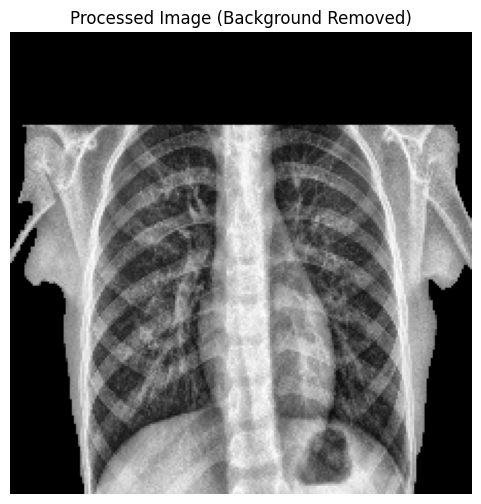

In [4]:
import matplotlib.pyplot as plt

# Path to your image
image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg"

# Process the image
processed_img = remove_background_otsu(image_path)

# Check if the image was processed correctly
if processed_img is not None:
    # Convert from BGR to RGB for correct visualization in Matplotlib
    processed_img_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(processed_img_rgb)
    plt.axis("off")  # Hide axis
    plt.title("Processed Image (Background Removed)")
    plt.show()
else:
    print("Error: Could not process the image. Check the file path.")


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_paths, labels, batch_size=32, augment=False, visualize=False):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.visualize = visualize
        self.visualization_done = False  # Track if visualization has been shown
        
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest')
        else:
            self.datagen = ImageDataGenerator()

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        
        batch_images = []
        valid_labels = []

        for img_path, label in zip(batch_files, batch_labels):
            img = remove_background_otsu(img_path, save=False)  # Otsu background removal
            
            if img is None:
                print(f"Warning: Background removal failed for {img_path}")  # Debugging
                continue  # Skip this image

            batch_images.append(img)
            valid_labels.append(label)

        if len(batch_images) == 0:
            raise ValueError("No valid images found in batch!")

        batch_images = np.array(batch_images, dtype=np.float32)  # Don't divide by 255.0 manually
        valid_labels = np.array(valid_labels)

        if self.visualize and not self.visualization_done:  # Only visualize once
            self.visualize_images(batch_images)
            self.visualization_done = True  # Set flag so it doesn't repeat

        # If augmentation is enabled, apply it and return the batch
        if self.augment:
            return next(self.datagen.flow(batch_images, valid_labels, batch_size=len(batch_images), shuffle=True))
        
        return batch_images, valid_labels

    def visualize_images(self, images, num_images=3):
        """Visualize first few processed images before augmentation."""
        fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
        for i in range(num_images):
            axes[i].imshow(images[i])
            axes[i].axis("off")
        
        plt.suptitle("Otsu Background Removed X-rays (First Few Samples)")
        plt.show()


In [6]:
import os
def load_dataset(base_dir):
    """
    Loads dataset file paths and corresponding labels.
    """
    categories = ["NORMAL", "PNEUMONIA"]
    file_paths, labels = [], []

    for label, category in enumerate(categories):
        category_path = os.path.join(base_dir, category)
        for filename in os.listdir(category_path):
            file_paths.append(os.path.join(category_path, filename))
            labels.append(label)

    return file_paths, labels

# Define dataset directories
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

# Load dataset paths and labels
train_files, train_labels = load_dataset(train_dir)
val_files, val_labels = load_dataset(val_dir)
test_files, test_labels = load_dataset(test_dir)


In [7]:
from sklearn.utils.class_weight import compute_class_weight

# Get unique class labels and their counts
unique_labels = np.unique(train_labels)
class_weights = compute_class_weight(class_weight="balanced", classes=unique_labels, y=train_labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [8]:
train_generator_no_bg = CustomDataGenerator(train_files, train_labels, augment=False, visualize=True)
train_generator_aug_no_bg = CustomDataGenerator(train_files, train_labels, augment=True, visualize=True)

val_generator_no_bg = CustomDataGenerator(val_files, val_labels, augment=False)
val_generator_aug_no_bg = CustomDataGenerator(val_files, val_labels, augment=True)

test_generator_no_bg = CustomDataGenerator(test_files, test_labels, augment=False)

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_resnet50_new(fine_tune_layers=5, dropout_rate=0.5, learning_rate=1e-5):
    """Builds a ResNet50 model with optional Grad-CAM support."""

    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last `fine_tune_layers`
    for layer in base_model.layers[-fine_tune_layers:]:
        layer.trainable = True

    # Custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=output)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    # Grad-CAM model: outputs last conv layer + final prediction
    grad_model = Model(
        inputs=model.input,
        outputs=[
            base_model.get_layer("conv5_block3_out").output,  # Last conv layer for Grad-CAM
            model.output
        ]
    )

    return model, grad_model


In [24]:
# Build model for no-background dataset
model_resnnoaug_no_bg, grad_model_resnoaug_no_bg = build_resnet50_new()

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Train model on no-background dataset
history_resnet_no_bg = model_resnnoaug_no_bg.fit(
    train_generator_no_bg,
    validation_data=val_generator_no_bg,
    epochs=10,
    class_weight=class_weight_dict,
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 136s 705ms/step - accuracy: 0.4453 - loss: 0.8335 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 706ms/step - accuracy: 0.6777 - loss: 0.5714 - val_accuracy: 0.3125 - val_loss: 0.7200
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 675ms/step - accuracy: 0.7348 - loss: 0.5262 - val_accuracy: 0.5000 - val_loss: 0.8283
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 659ms/step - accuracy: 0.8034 - loss: 0.4047 - val_accuracy: 0.5000 - val_loss: 0.7464
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 674ms/step - accuracy: 0.8089 - loss: 0.4065 - val_accuracy: 0.5000 - val_loss: 1.1131
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 664ms/step - accuracy: 0.8351 - loss: 0.3725 - val_accuracy: 0.5000 - val_loss: 0.8053
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 158s 764ms/step - accuracy: 0.8578 - loss: 0.3335 - val_accuracy: 0.4375 - val_loss: 0.9216
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 136s 795ms/step - accuracy: 0.8781 -

In [32]:
model_resnnoaug_no_bg.save("/kaggle/working/model_resnet_no_bg.h5")
import os
if os.path.exists("/kaggle/working/model_resnet_no_bg.h5"):
    print("✅ Model saved successfully!")
else:
    print("❌ Model not saved.")


✅ Model saved successfully!


In [33]:
from tensorflow.keras.models import load_model

loaded_model_2 = load_model("/kaggle/working/model_resnet_no_bg.h5")
print(loaded_model_2.summary())  # Verify the architecture


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,858,307 (91.01 MB)

 Trainable params: 1,321,217 (5.04 MB)

 Non-trainable params: 22,537,088 (85.97 MB)

 Optimizer params: 2 (12.00 B)

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


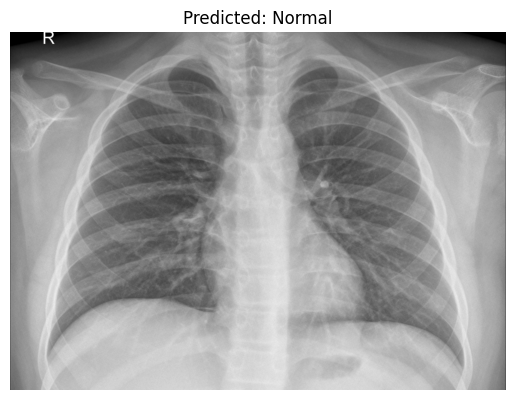

In [34]:
# Load and preprocess an image
image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0021-0001.jpeg"  # Update this path
image_no_bg = remove_background_otsu(image_path)
class_names = ["Normal", "Pneumonia"]
if image_no_bg is not None:
    image_array = np.expand_dims(image_no_bg, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = loaded_model_2.predict(image_array)
    predicted_class = class_names[int(prediction[0][0] > 0.5)]  # Binary classification
    
    # Display image and prediction
    plt.imshow(cv2.imread(image_path)[..., ::-1])  # Convert BGR to RGB
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")
    plt.show()
else:
    print("❌ Error: Unable to process image.")

In [35]:
# Load test dataset
class_names = ["NORMAL", "PNEUMONIA"]
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"  # Update this path
true_labels = []
pred_labels = []

for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(test_dir, class_name)
    
    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)
        
        image_no_bg = remove_background_otsu(image_path)
        if image_no_bg is None:
            continue
        
        image_array = np.expand_dims(image_no_bg, axis=0)  # Add batch dimension
        prediction = loaded_model_2.predict(image_array)
        
        pred_class = int(prediction[0][0] > 0.5)  # Binary classification
        
        true_labels.append(class_idx)
        pred_labels.append(pred_class)

# Generate classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import cv2

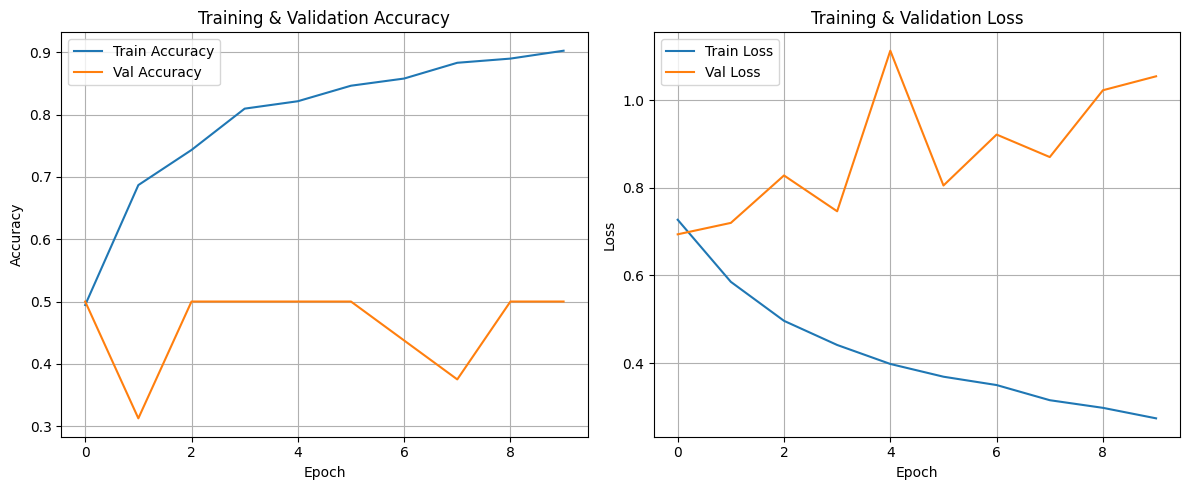

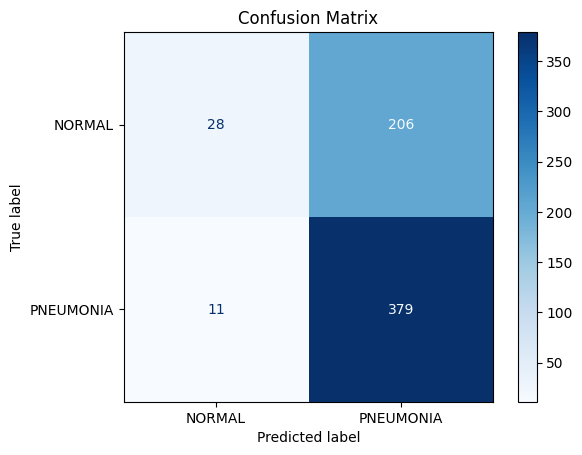

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.72      0.12      0.21       234
   PNEUMONIA       0.65      0.97      0.78       390

    accuracy                           0.65       624
   macro avg       0.68      0.55      0.49       624
weighted avg       0.67      0.65      0.56       624



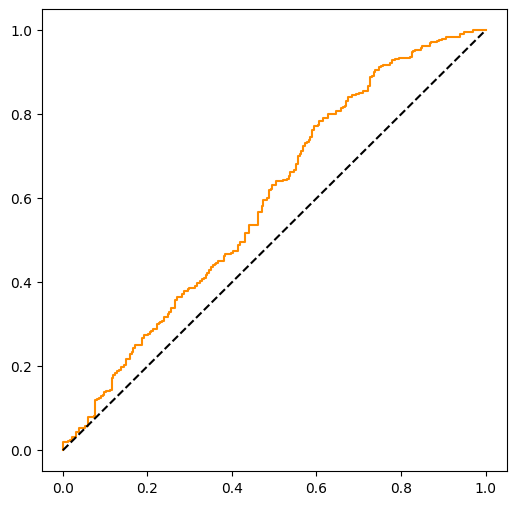

In [45]:
# Predict on test set
y_pred_prob = model_resnnoaug_no_bg.predict(test_generator_no_bg, verbose=0)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()
class_labels = ['NORMAL', 'PNEUMONIA'] 

# Accuracy & Loss Curves
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_resnet_no_bg.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet_no_bg.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_resnet_no_bg.history['loss'], label='Train Loss')
plt.plot(history_resnet_no_bg.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc

# Extract ground truth
y_true = []
for i in range(len(test_generator_no_bg)):
    _, labels = test_generator_no_bg[i]
    y_true.extend(labels)
y_true = np.array(y_true).flatten()

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc, color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')


In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img_array = np.expand_dims(img, axis=0)
    return img_array, img

def grad_cam(model, grad_model, img_array):
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    pooled_grads = pooled_grads.numpy()
    conv_output = conv_output.numpy()

    heatmap = np.dot(conv_output, pooled_grads)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap + 1e-8)  # prevent division by 0
    heatmap = cv2.resize(heatmap, (224, 224))

    return heatmap

def display_grad_cam(img_path, model, grad_model):
    img_array, original_img = preprocess_image(img_path)
    heatmap = grad_cam(model, grad_model, img_array)

    plt.imshow(original_img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Grad-CAM')
    plt.show()


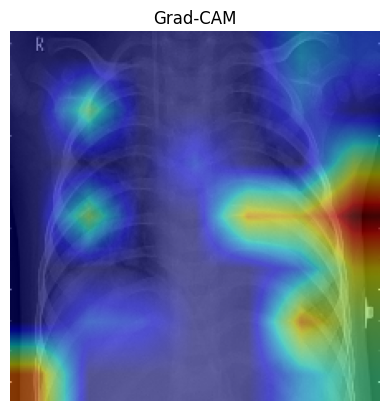

In [47]:
img_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person101_bacteria_485.jpeg"
display_grad_cam(img_path, model_resnnoaug_no_bg,grad_model_resnoaug_no_bg )
